In [1]:
from tensorflow import data, keras
import h5py
import numpy as np

2025-10-06 13:04:05.652934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/u/markhoff/Kitten/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Loading File

- .h5 format allows for chunking when training on large datasets. This is nice for clusters where memory size is limited. However, in the implementation below, the entire file is loaded into memory. This is okay for testing, but will need to be thought about for cluster training.

In [ ]:
with h5py.File('70DEG.h5', 'r') as f:
    X = f['X'][:]
    Y = f['Y'][:]/2 - 1

n_events = X.shape[0] # Assume X.shape = (n_events, n_features), Y.shape = (n_events)

In [10]:
# ---------------------------------------------------------------
#
#                       PARAMETERS
#
# ---------------------------------------------------------------
class_names = ['Pi+', 'Proton']
num_classes = len(class_names) # Pions or kaons?


batch_size  = 128 # How many events to feed to NN at a time?
nepochs     = 5 # How many epochs?

# Splits
train_frac  = 0.7
val_frac    = 0.15
test_frac   = 0.15

# ---------------------------------------------------------------

# Preparing Datasets

In [11]:
# Preparing data

# Shuffle the entire dataset to remove any ordering (e.g., angular dependence)
rng = np.random.default_rng(seed=1)  # for reproducibility
indices = rng.permutation(n_events)
X = X[indices]
Y = Y[indices]

train_end   = int(n_events*train_frac)
print(f'Training on {train_end} events')
val_end     = train_end + int(n_events*val_frac)

X_train, Y_train    = X[:train_end]       , Y[:train_end]
X_val, Y_val        = X[train_end:val_end], Y[train_end:val_end]
X_test, Y_test      = X[val_end:]         , Y[val_end:]

train_ds = data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(buffer_size=1024)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(data.AUTOTUNE)

val_ds   = data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds   = val_ds.batch(batch_size)
val_ds   = val_ds.prefetch(data.AUTOTUNE)

test_ds  = data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds  = test_ds.batch(batch_size)
test_ds  = test_ds.prefetch(data.AUTOTUNE)

input_dim = X.shape[1]
print(f'Input dimension: {input_dim}')

Training on 22960 events
Input dimension: 10240


# Defining and Training

In [12]:
num_nodes = 16

print(f'\n\nTraining with {num_nodes} nodes in hidden layer\n')

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(input_dim,)),
    keras.layers.Dense(num_nodes, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_nodes, activation='relu'),
    keras.layers.Dense(num_classes)
    ])

model.compile(optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=nepochs)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)




Training with 16 nodes in hidden layer

Epoch 1/5


/u/markhoff/Kitten/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5142 - loss: 0.6926 - val_accuracy: 0.5565 - val_loss: 0.6909
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5970 - loss: 0.6794 - val_accuracy: 0.5610 - val_loss: 0.6830
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6419 - loss: 0.6430 - val_accuracy: 0.5614 - val_loss: 0.6930
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6733 - loss: 0.6109 - val_accuracy: 0.5616 - val_loss: 0.7118
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6943 - loss: 0.5840 - val_accuracy: 0.5567 - val_loss: 0.7352
39/39 - 0s - 6ms/step - accuracy: 0.5673 - loss: 0.7254


In [6]:
%%script false --no-raise-error

import time
import numpy as np

accs = []
effys = []
times = []

preds = []

for num_nodes in range(2, 17, 1):
    print(f'\n\nTraining with {num_nodes} nodes in hidden layer\n')
    t1 = time.time()

    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(input_dim,)),
        keras.layers.Dense(num_nodes, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(num_nodes, activation='relu'),
        keras.layers.Dense(num_classes)
        ])

    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_ds, validation_data=val_ds, epochs=nepochs)

    test_loss, test_acc = model.evaluate(test_ds, verbose=2)

    probability_model = keras.Sequential([model, 
                                         keras.layers.Softmax()])

    predictions = probability_model.predict(test_ds)
    confidence = 0.95 # p-value (1 sigma = 0.68, 2 sigma = 0.95, 3 sigma = 0.997, etc)

    correct     = 0
    total       = 0

    Y_test_labels = np.array([y.numpy() for _, y in test_ds.unbatch()])

    for i, pred in enumerate(predictions):
        preds.append((np.argmax(pred), np.max(pred)))
        if pred[np.argmax(pred)] >= confidence:
            total += 1
            if np.argmax(pred) == Y_test_labels[i]:
                correct += 1

    t2 = time.time()


    accs.append(correct/total if total > 0 else np.nan)
    effys.append(total/predictions.shape[0])
    times.append(t2-t1)
    
    print(f'\nTest accuracy: {test_acc}, time: {t2-t1} s')

print(f'\n\nAccuracies: {accs}')
print(f'Efficiencies: {effys}')
print(f'Times: {times}')
print(preds)
np.save('predictions.npy', preds)

# Efficiency Evaluation

- If a prediction for a given event does not reach significance, it is disgarded. Only events which reach significance count towards efficiency. 

- Significant events that are correct are recorded as a correct prediction. Significant events that are wrong are recorded as an incorrect prediction.

In [13]:
probability_model = keras.Sequential([model, 
                                         keras.layers.Softmax()])

predictions = probability_model.predict(test_ds)
confidence = 0.05 # p-value (2 sigma = 0.05, 3 sigma = 0.003, etc)

correct     = 0
total       = 0

Y_test_labels = np.array([y.numpy() for _, y in test_ds.unbatch()])

for i, pred in enumerate(predictions):
    if pred[np.argmax(pred)] >= 1 - confidence:
        total += 1
        if np.argmax(pred) == Y_test_labels[i]:
            correct += 1

try:
    print(f'Accuracy: {correct} out of {total}... {correct/total:0.5f}\nEvents Kept: {total} out of {predictions.shape[0]}... {total/predictions.shape[0]:0.5f}')
except ZeroDivisionError:
    print('No events kept!')

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 1 out of 3... 0.33333
Events Kept: 3 out of 4920... 0.00061


# Test for Dataset

- This code checks if there are any duplicate events in the dataset, and gives the confusion matrix of the NN.

Checking for overlap between splits:
Overlap between Train and Val: 0 events
Overlap between Train and Test: 0 events
Overlap between Val and Test: 0 events
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2025-10-06 13:24:06.106928: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


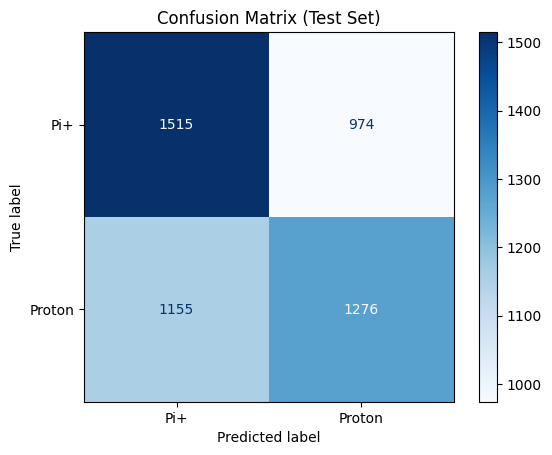

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Check for overlap between train, val, and test sets (independence) ---
# We'll check if any rows in X_train, X_val, X_test are identical

def check_overlap(X1, X2, name1="Set1", name2="Set2"):
    # Convert to a set of tuples for fast comparison
    set1 = set(map(tuple, X1))
    set2 = set(map(tuple, X2))
    overlap = set1 & set2
    print(f"Overlap between {name1} and {name2}: {len(overlap)} events")
    return len(overlap)

print("Checking for overlap between splits:")
check_overlap(X_train, X_val, "Train", "Val")
check_overlap(X_train, X_test, "Train", "Test")
check_overlap(X_val, X_test, "Val", "Test")

# --- Confusion Matrix on Test Set ---
# Get predictions for test set
probability_model = keras.Sequential([model, keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.array([y.numpy() for _, y in test_ds.unbatch()])

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()